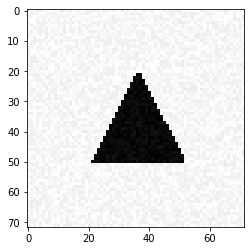

In [35]:
import matplotlib.pyplot as plt
#%matplotlib inline
import keras
import numpy as np
from keras import utils as np_utils
import tensorflow
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test=keras.utils.np_utils.to_categorical(Y_test,3)
    #Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


## Travail à faire

#### Réseau de neurones 1:

In [36]:
[X_train,y_train]=generate_dataset_classification(300,20)
[X_test,Y_test]=generate_test_set_classification()

#print(y_train)
#print(X_train.shape) #(300,5184)
#print(y_train.shape) #(300,)
#print(X_test.shape) #(300, 5184)
#print(Y_test.shape) #(300, 3)

num_pixels = X_train.shape[1]
y_train = keras.utils.np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [38]:
def neural_network1():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu', kernel_initializer='normal'))
    model.add(Dense(3,activation='softmax',kernel_initializer='normal'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model=neural_network1()
model.summary()
model.fit(X_train, y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=100)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 5184)              26879040  
                                                                 
 dense_19 (Dense)            (None, 3)                 15555     
                                                                 
Total params: 26,894,595
Trainable params: 26,894,595
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 263ms/step - loss: 169.3376 - accuracy: 0.3333 - val_loss: 306.1366 - val_accuracy: 0.3300
Epoch 2/10
3/3 [==============================] - 1s 210ms/step - loss: 186.8160 - accuracy: 0.3333 - val_loss: 149.1775 - val_accuracy: 0.3400
Epoch 3/10
3/3 [==============================] - 1s 207ms/step - loss: 91.4605 - accuracy: 0.3833 - val_loss: 37.0653 - val_accuracy: 0.3300
Epoch 4/

In [39]:
#evaluation
scores = model.evaluate(X_test, Y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100)) #best accuracy: 41,67%

10/10 [==============================] - 0s 21ms/step - loss: 19.7767 - accuracy: 0.3967
Neural network accuracy: 39.67%


In [40]:
#prediction
prediction = model.predict([X_test])
print(prediction)

[[6.35538172e-21 1.06602974e-05 9.99989390e-01]
 [7.40590949e-17 1.43725812e-01 8.56274188e-01]
 [5.38394968e-22 1.54365026e-07 9.99999881e-01]
 [4.26615118e-19 3.86448892e-06 9.99996185e-01]
 [1.75249202e-14 1.59298888e-05 9.99984026e-01]
 [9.66561803e-17 5.22170376e-06 9.99994755e-01]
 [4.26134896e-21 4.98429520e-09 1.00000000e+00]
 [3.79406557e-24 3.32252732e-11 1.00000000e+00]
 [1.71498322e-20 2.35833353e-09 1.00000000e+00]
 [9.75923277e-22 1.45683257e-11 1.00000000e+00]
 [4.10858691e-17 4.74845961e-04 9.99525189e-01]
 [2.17292511e-21 2.91941574e-13 1.00000000e+00]
 [2.74831718e-17 3.39711230e-04 9.99660254e-01]
 [2.33027239e-23 4.99864983e-10 1.00000000e+00]
 [5.27502376e-22 3.69453268e-08 1.00000000e+00]
 [5.21463436e-25 3.70724312e-13 1.00000000e+00]
 [2.34586407e-22 5.06446881e-12 1.00000000e+00]
 [2.81675597e-15 1.37927680e-06 9.99998569e-01]
 [1.15812379e-22 1.41569784e-10 1.00000000e+00]
 [8.42617674e-24 2.98895839e-11 1.00000000e+00]
 [2.96977429e-22 4.84038698e-10 1.000000

In [41]:
i = 0
pred = np.argmax(prediction[i])
while pred != 1:
    i += 1
    pred = np.argmax(prediction[i])


print(pred)
print(i)

1
29


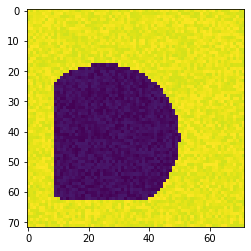

In [42]:
import matplotlib.pyplot as plt

img_rows,img_cols=72,72
X_test=X_test.reshape(X_test.shape[0],img_rows,img_cols,1)
plt.imshow(X_test[i])
plt.show()

#### Réseau de neurones 2:

In [21]:
[X_train,y_train]=generate_dataset_classification(300,20,True)
[X_test,Y_test]=generate_test_set_classification()

#print(y_train)
#print(X_train.shape) #(300,5184)
#print(y_train.shape) #(300,)
#print(X_test.shape) #(300, 5184)
#print(Y_test.shape) #(300, 3)

num_pixels = X_train.shape[1]
y_train = keras.utils.np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [24]:
def neural_network2():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu', kernel_initializer='normal'))
    model.add(Dense(num_classes,activation='softmax',kernel_initializer='normal'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

model=neural_network2()
model.summary()
model.fit(X_train, y_train, validation_data=(X_test,Y_test), epochs=10, batch_size=100)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5184)              26879040  
                                                                 
 dense_13 (Dense)            (None, 3)                 15555     
                                                                 
Total params: 26,894,595
Trainable params: 26,894,595
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 217ms/step - loss: 138.9612 - accuracy: 0.3733 - val_loss: 18.9704 - val_accuracy: 0.3733
Epoch 2/10
3/3 [==============================] - 0s 141ms/step - loss: 71.1213 - accuracy: 0.2933 - val_loss: 13.1603 - val_accuracy: 0.3900
Epoch 3/10
3/3 [==============================] - 0s 183ms/step - loss: 16.6513 - accuracy: 0.3900 - val_loss: 11.3526 - val_accuracy: 0.3967
Epoch 4/10


In [25]:
#evaluation
scores = model.evaluate(X_test, Y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100)) #best accuracy: 59.33%

10/10 [==============================] - 0s 19ms/step - loss: 0.8205 - accuracy: 0.5933
Neural network accuracy: 59.33%


In [26]:
#prediction
prediction = model.predict([X_test])
print(prediction)

[[4.00603354e-01 1.22952618e-01 4.76444036e-01]
 [1.60112590e-01 9.73926336e-02 7.42494762e-01]
 [3.93289804e-01 3.78260344e-01 2.28449821e-01]
 [1.43577218e-01 8.26955773e-03 8.48153174e-01]
 [8.95412117e-02 8.25419188e-01 8.50395262e-02]
 [4.22761223e-04 9.99408364e-01 1.68911152e-04]
 [2.30093434e-01 9.44503490e-03 7.60461509e-01]
 [3.50341618e-01 1.13011813e-02 6.38357282e-01]
 [2.70221472e-01 8.81261192e-03 7.20965922e-01]
 [4.63568211e-01 2.18622878e-01 3.17808896e-01]
 [1.06014706e-01 1.01136426e-02 8.83871615e-01]
 [3.16315033e-02 9.20646012e-01 4.77225296e-02]
 [1.23927087e-01 1.71029922e-02 8.58969986e-01]
 [2.46179253e-01 1.13585182e-02 7.42462277e-01]
 [3.32753092e-01 9.01474059e-03 6.58232152e-01]
 [3.94528396e-02 8.89359117e-01 7.11879730e-02]
 [5.10327779e-02 9.11371529e-01 3.75957452e-02]
 [1.97461322e-01 7.98786640e-01 3.75207607e-03]
 [3.19393158e-01 1.28315752e-02 6.67775273e-01]
 [3.56351316e-01 1.30100297e-02 6.30638659e-01]
 [1.93033770e-01 5.12824999e-03 8.018380

In [27]:
i = 0
pred = np.argmax(prediction[i])
while pred != 1:
    i += 1
    pred = np.argmax(prediction[i])


print(pred)
print(i)

1
4


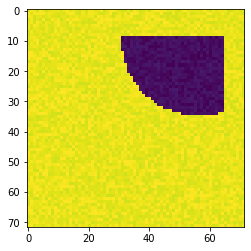

In [28]:
import matplotlib.pyplot as plt

img_rows,img_cols=72,72
X_test=X_test.reshape(X_test.shape[0],img_rows,img_cols,1)
plt.imshow(X_test[i])
plt.show()

Le modele généré par la ligne "generate_dataset_classification(300,20,True)" est meilleur que le premier modèle. Il a une meilleur accuracy (59%).

#### Architecture CNN:

In [137]:
[X_train,y_train]=generate_dataset_classification(300,20,True)
[X_test,Y_test]=generate_test_set_classification()

img_rows,img_cols=72,72
X_train=X_train.reshape(X_train.shape[0],img_rows,img_cols,1)
X_test=X_test.reshape(X_test.shape[0],img_rows,img_cols,1)

num_pixels = X_train.shape[1]
y_train = keras.utils.np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [138]:
def CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72,72,1), padding='same',strides=(1,1))) # the (3,3) specifies the shape of the convolutional kernel.
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(72,72,1), padding='same',strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = CNN()
model.summary()
#entrainement
model.fit(X_train, y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=10) 

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        320       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 64)       0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 20736)             0         
                                                                 
 dense_104 (Dense)           (None, 100)             

In [139]:
#evaluation
scores = model.evaluate(X_test, Y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100)) #best accuracy:84%

10/10 [==============================] - 0s 32ms/step - loss: 0.6266 - accuracy: 0.8400
Neural network accuracy: 84.00%


On voit que le modèle cnn a une bien meilleur accuracy que les 2 premiers modèles.